# Importing packages and load CNN

In [1]:
# Load the extension
%load_ext autoreload
# Autoreload all modules
%autoreload 2

In [2]:
from funcs import *

# Telling the notebook to make plots inline.
%matplotlib inline

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)

Saving imgages in /home/controls/Beam_auto_alignment/Data/Actual_cavity_Fittest_points_per_gen_2019-11-12_18-55

Cavity Mirror scanning range is [0, 2.8e-06] micron. The used range [0, 1.4e-07] micron should not go out.
Steering Mirror scanning range is [-0.0262, 0.0262] rad. The used range [-0.0262, 0.0262] rad should not go out.


## Start camera and DAC

In [3]:
camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
print("Using Camera ", camera.GetDeviceInfo().GetModelName())
camera.Open()

# Sanity checks
print('Camera Auto Gain is :', camera.GainAuto())
if camera.GainAuto() == 'Off':
    print('Safe to go ahead with the code..')
else:
    print('***Warning: Camera Auto Gain is ON!***\nTurn it off using Pylon software.')
camera.ExposureTimeAbs = Exposure

# Start DAC
start_channel = 1
bus = busworks.BusWorks_DAC()
bus.start()
print("DAC on IP: ", bus.address)

Using Camera  acA720-290gm
Camera Auto Gain is : Off
Safe to go ahead with the code..
DAC on IP:  192.168.1.231


## Initial State

Initial condition: 0.0078125


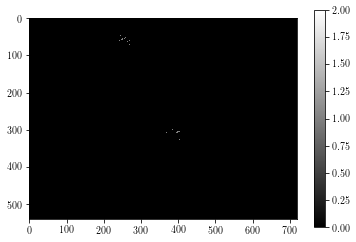

In [4]:
Img_initial = Capture_image(1000, camera)
print('Initial condition: {}'.format(Img_initial.sum()/n_pixl**2))
plt.imshow(Img_initial[::-1], cmap=cm.binary_r)
plt.colorbar()

In [5]:
# Initial condition of beam
current_beam_status = np.zeros(num_params)

## Alignment loop


Range: 2.0 x waist


 Gen: 1 Range: 1.2783086873522436 x waist


/home/controls/Beam_auto_alignment/src/funcs.py:120: RuntimeWarning: invalid value encountered in true_divide
  Basis_vect /= float(np.sqrt(Basis_vect[0]**2. + Basis_vect[1]**2.))
/home/controls/Beam_auto_alignment/src/funcs.py:123: RuntimeWarning: invalid value encountered in long_scalars
  slope /= (P1[0]-P0[0])
/home/controls/Beam_auto_alignment/src/funcs.py:123: RuntimeWarning: divide by zero encountered in long_scalars
  slope /= (P1[0]-P0[0])
/home/controls/Beam_auto_alignment/src/funcs.py:127: RuntimeWarning: divide by zero encountered in double_scalars
  m = vect[1] / vect[0]


Time: 29.664350509643555, Fittest Parent: [ 6.30697895e-04 -4.79005727e-04 -3.58042471e-04 -7.77224147e-04
 -7.50811524e-08], Fitness: 8.543182373046875


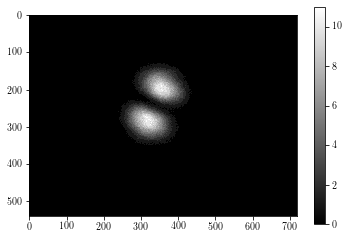

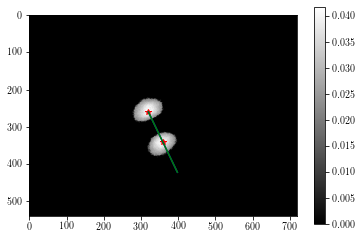


*****  Mode is (0, 1) - occurances: 1  *****



 Gen: 2 Range: 0.817036550080108 x waist
Time: 60.6862096786499, Fittest Parent: [ 1.60567384e-03 -4.72162099e-04  1.09793857e-03  2.17453132e-03
  3.40371350e-07], Fitness: 88.41342163085938


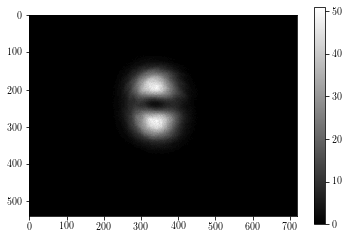

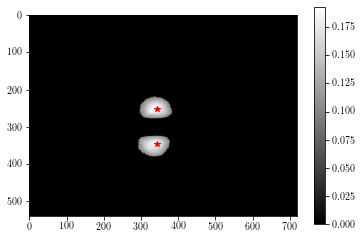


*****  Mode is (0, 1) - occurances: 2  *****



 Gen: 3 Range: 0.5222124599258542 x waist
Time: 91.30080127716064, Fittest Parent: [ 3.65361111e-04 -1.55715087e-03  1.45121003e-03  6.91890289e-04
  1.90210712e-07], Fitness: 24.74078369140625


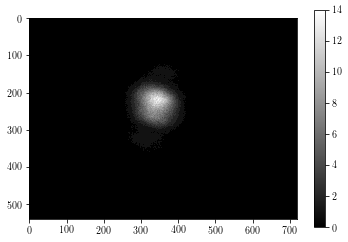

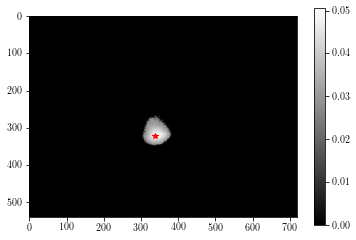


*****  Mode is (0, 0) - occurances: 1  *****



 Gen: 4 Range: 0.3337743620834024 x waist
Time: 120.9995973110199, Fittest Parent: [-2.01906109e-04 -2.96270517e-04  1.95832689e-04 -5.50578326e-04
  1.18486819e-07], Fitness: 128.32275390625


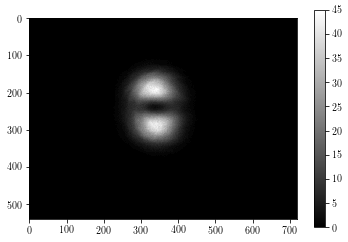

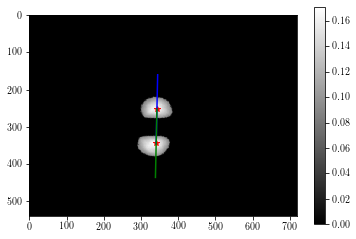


*****  Mode is (0, 1) - occurances: 1  *****



 Gen: 5 Range: 0.2133333333333333 x waist
Time: 150.38316774368286, Fittest Parent: [-1.08076327e-04 -7.68160603e-04 -3.57644545e-04  4.47746322e-04
 -1.96219413e-07], Fitness: 157.66668701171875


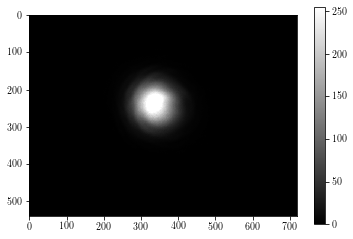

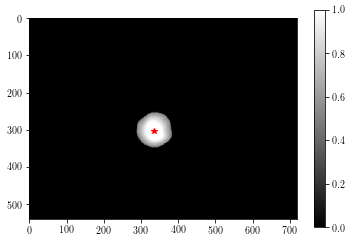


*****  Mode is (0, 0) - occurances: 1  *****



 Gen: 6 Range: 0.13635292665090595 x waist
Time: 178.20186567306519, Fittest Parent: [-1.04237008e-05 -6.85837396e-04 -3.01736625e-04  6.29671656e-05
 -3.74949082e-08], Fitness: 200.315673828125


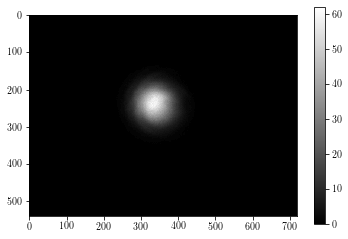

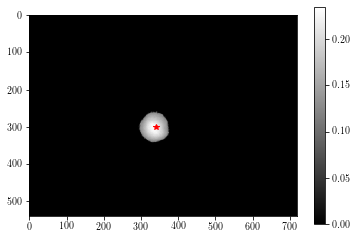


*****  Mode is (0, 0) - occurances: 2  *****



 Gen: 7 Range: 0.08715056534187816 x waist
Time: 205.83173990249634, Fittest Parent: [-3.53442770e-05 -3.03860741e-05  9.79194441e-05  6.06333794e-04
 -4.96026986e-08], Fitness: 220.3939208984375


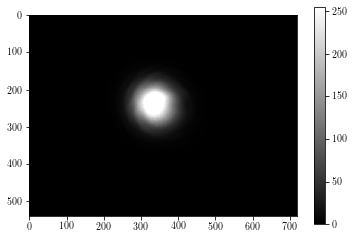

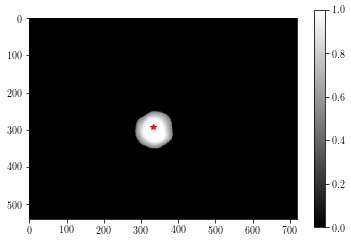


*****  Mode is (0, 0) - occurances: 3  *****



 Gen: 8 Range: 0.0557026623920911 x waist
Time: 233.4681215286255, Fittest Parent: [ 3.30270503e-05 -8.15263055e-06  8.17960067e-05  1.26750542e-04
 -3.70610119e-08], Fitness: 217.35009765625


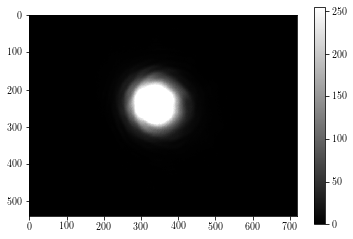

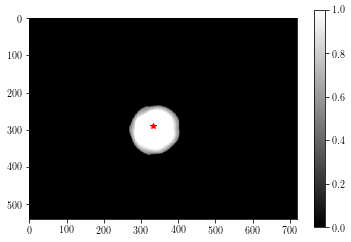


*****  Mode is (0, 0) - occurances: 4  *****



 Gen: 9 Range: 0.03560259862222958 x waist
Time: 262.0667209625244, Fittest Parent: [-3.79712272e-05 -9.37746465e-05  8.83731185e-05  2.02305056e-04
 -2.33387463e-08], Fitness: 267.4716796875


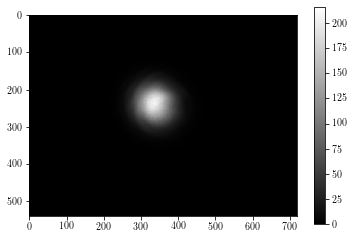

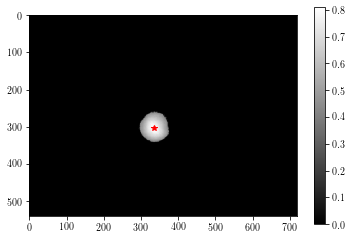


*****  Mode is (0, 0) - occurances: 5  *****



 Gen: 10 Range: 0.022755555555555546 x waist
Time: 291.04409742355347, Fittest Parent: [-6.31029655e-05  4.06091086e-05 -5.85574362e-05  2.43621687e-05
  1.42286867e-08], Fitness: 252.37274169921875


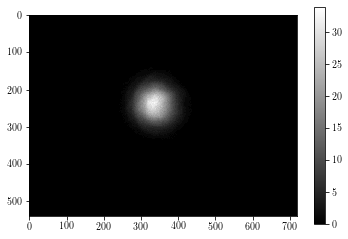

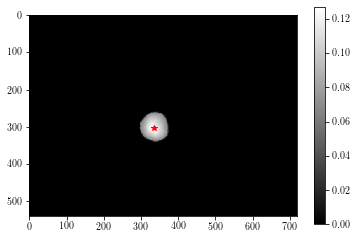

Fundamental mode identified! Exiting..


In [6]:
Range = Range_orig
# Creating the initial population of deltas
new_pop_deltas = sample_d(Range, shape=pop_size)
print("\nRange:", Range, "x waist")
# sess = tf.Session()

gen = 0
mode_stability = 0
mode_old = (50,50)
# dont_alter_z_cm = False
t0 = time.time()

# GA loop
for gen in range(100):
    # Shrink range
    Range *= shrink_factor
    print("\n\n Gen: {} Range: {} x waist".format(gen+1, Range))
    # if dont_alter_z_cm:
    #     new_pop_deltas[:,-1] = 0.
    if gen == 0:
        current_beam_status, new_pop_deltas, fitness = calc_pop_fitness(current_beam_status, \
        new_pop_deltas, fitness, camera, bus, only_offsprings=False)
    else:
        current_beam_status, new_pop_deltas, fitness = calc_pop_fitness(current_beam_status, \
        new_pop_deltas, fitness, camera, bus, only_offsprings=True)
    # Selecting the best parents in the population for mating.
    current_beam_status, parents, parents_fitness, Img_is_saturated, image = select_mating_pool(current_beam_status, new_pop_deltas, fitness, num_parents_mating, t0, gen, camera, bus, \
                           show_the_best=True, save_best=True)
    # Generating next generation using crossover.
    offspring_crossover = crossover(parents, (pop_per_gen - num_parents_mating, num_params))
    # Adding some variations to the offsrping using mutation.
    offspring_mutation = mutation(offspring_crossover, Range)
    # Creating the new population based on the parents and offspring.
    new_pop_deltas[:num_parents_mating, :] = parents
    new_pop_deltas[num_parents_mating:, :] = offspring_mutation
    fitness[:num_parents_mating] = parents_fitness
    fitness[num_parents_mating:] *= 0.
    # # Scan the cavity and regain the max power point in z_CM
    # current_beam_status, new_pop_deltas, img = scan_cavity(current_beam_status, new_pop_deltas, \
    #                                                        Range, Sz, camera, bus, show_fig=True)
    mode_new = Find_mode2(image, separation1=45, corner=0, show_fig=True, show_basis=True)
    if gen > 0:
        if np.all(mode_new == mode_old):
            mode_stability += 1
        else:
            mode_stability = 0
        # check mode stability
        if mode_stability == 3 and np.any(mode_new != (0,0)):
            print('Jumping to fundamental mode..')
            current_beam_status, new_pop_deltas, _ = jump_2_fundamental(current_beam_status, new_pop_deltas, \
                                                                        mode_new, camera, bus, show_fig=True)
        elif mode_stability > 3 and np.any(mode_new != (0,0)):
            print('Trying alternate jump..')
            current_beam_status, new_pop_deltas, _ = jump_2_fundamental(current_beam_status, new_pop_deltas, \
                                                                        mode_new, camera, bus, Sign=-1, show_fig=True)
            print('Scanning the cavity..')
            current_beam_status, new_pop_deltas, img = scan_cavity(current_beam_status, new_pop_deltas, \
                                                                   1.1*Range, Sz, camera, bus, show_fig=True)
        elif mode_stability == 5 and np.all(mode_new == (0,0)):
            print('Fundamental mode identified! Exiting..')
            break
    print('\n*****  Mode is {} - occurances: {}  *****\n'.format(mode_new, mode_stability+1))
    mode_old = mode_new

    # if Img_is_saturated or max(fitness) > 200. or gen > 15:
    #     Range = Range_orig*shrink_factor**4
    #     Img_is_saturated = False
    #     print('Testing mode...')
    #     mode = Find_mode2(image, separation1=5, corner=0, show_fig=True, show_basis=True)
    #     print('Mode is {}'.format(mode))
    #     if np.all(mode == (0,0)):
    #         print('Fundamental mode identified! Exiting..')
    #         break
    #     else:
    #         # taking a jump in z_CM to make the cavity resonant to fundamental mode only
    #         current_beam_status, new_pop_deltas, _ = jump_2_fundamental(current_beam_status, new_pop_deltas, \
    #                                                                     mode, camera, bus, show_fig=True)
    #         # freezing z_CM 
    #         # dont_alter_z_cm = True

# Plot status

27.2239990234375


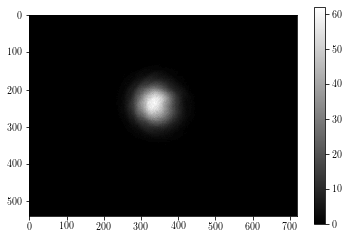

In [27]:
Img1 = Capture_image(300, camera)
print(Img1.sum()/n_pixl**2)
plt.imshow(Img1[::-1], cmap=cm.binary_r)
plt.colorbar()

# Stop Camera and DAC

In [ ]:
# # Stop camera and DAC
camera.Close()
bus.stop()

## Make gif of the images

In [29]:
import imageio

files = os.listdir(ImagesFolder)
files.sort()
images = []
for filename in files:
    images.append(imageio.imread(ImagesFolder+'/'+filename))
imageio.mimsave(ImagesFolder + '/movie.gif', images, duration=0.5)

In [ ]:
# n_pixl=128
# RepoDir = '../'
# TrainingDataFolder = RepoDir + 'Data/Actual_cavity_Fittest_points_per_gen_2019-11-08_19-50/'
# img_loc = TrainingDataFolder + 'Gen_09_time_205_Power_271.07_alignments_0.000000_0.000000_0.000000_0.000000_endMirror_0.000000.png'
# im = imageio.imread(img_loc)[48:245,56:320,0]
# plt.imshow(im)
# plt.colorbar()
# mode_new = Find_mode2(im, separation1=45, corner=0, show_fig=True, show_basis=True)